In [107]:
# !pip install lazypredict

In [1]:
import os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from torchmetrics.functional import accuracy as ACC

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence
from torchsummary import summary

import time
import nltk
import json
import random
import unicodedata
import contractions
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action="ignore")

#data cleaning methods
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [21]:
class Load_Preprocess():
    def __init__(self):
        self.word2index = {}
        self.max_len = 0
        
        self.Label2num = {'Entailment': 1, "Contradiction": 0}

        self.train_df = self.Preprocess_df(pd.DataFrame.from_dict(self.load_Processed_Data(self.load_Processed_cTAKES('ctakes/Train_Statements_cTAKES_Processed.json'), 'train')), Train=True)
        self.val_df = self.Preprocess_df(pd.DataFrame.from_dict(self.load_Processed_Data(self.load_Processed_cTAKES('ctakes/Dev_Statements_cTAKES_Processed.json'), 'dev')))
        self.test_df = self.Preprocess_df(pd.DataFrame.from_dict(self.load_Processed_Data(self.load_Processed_cTAKES('ctakes/Test_Statements_cTAKES_Processed.json'), 'test')))
        
    def load_Processed_cTAKES(self, split):
        ctakes_tokens_path = split
        with open(ctakes_tokens_path) as json_file:
            ctakes_tokens = json.load(json_file)

        preferred_text_dict = dict()
        for i in range(len(ctakes_tokens)):
            cm_dict = ctakes_tokens[i]['clinical_mention']
            temp_list = []
            for key in cm_dict.keys():
                try:
                    temp_list.append(cm_dict[key][0]['preferredText'])
                except:
                    continue
            preferred_text_dict[ctakes_tokens[i]['UUID'][0]] = temp_list
        return preferred_text_dict

    def load_Processed_Data(self, ctakes, split):
        preferred_text = []
        statement = []
        trail1 = []
        trail2 = []
        section = []
        label = []
        
        with open(f"training_data/{split}" + ".json") as file:
            data = json.load(file)
            uuid_list = list(data.keys())

        for id in uuid_list:
            statement.append(data[id]['Statement'])
            if split != 'test':
                label.append(self.Label2num[data[id]['Label']])
            else:
                label.append(-1)
            section.append(data[id]['Section_id'])
        
            with open(f"training_data/CT json/{data[id]['Primary_id']}" + ".json") as file: 
                ct = json.load(file)
                trail1.append(self.join_list(ct[data[id]['Section_id']]))
                
            if data[id]['Type'] == "Comparison":  
                with open(f"training_data/CT json/{data[id]['Secondary_id']}" + ".json") as file:
                    ct = json.load(file)
                    trail2.append(self.join_list(ct[data[id]['Section_id']]))
            else:
                trail2.append("_")
                
            preferred_text.append(','.join(ctakes[id]))

        return {'preferred_text':preferred_text, 'statement':statement, 'trail1':trail1, 'trail2':trail2, 'section':section, 'label':label}
        
    def join_list(self, sentences):
        return ", ".join([sent.strip() for sent in sentences])
    
    def Preprocess_df(self, df, Train=False):
#         df['statement'] = df['statement'].apply(Preprocessing)
#         df['trail1'] = df['trail1'].apply(Preprocessing)
#         df['trail2'] = df['trail2'].apply(Preprocessing)

        df["#Words1"] = df["statement"].apply(lambda n: len(n.split()))
        df["#Words2"] = df["trail1"].apply(lambda n: len(n.split()))
        df["#Words3"] = df["trail2"].apply(lambda n: len(n.split()))
        
        if Train:
            self.Build_Vocabulary(df['statement'].tolist()+df['trail1'].tolist()+df['trail2'].tolist())
        return df

    def Build_Vocabulary(self, texts):
        words = ['', 'UNK']+list(set(' '.join(texts).split()))
        self.word2index = dict(zip(words, list(range(0, len(words)))))
        self.max_len = self.get_max_length(texts)
   
    def get_max_length(self, Texts):
        lens = [len(text.split(' ')) for text in Texts]
        print('index', lens.index(max(lens)))
        return max(lens)
    
    def Target_proportions(self, df):
        print(df.label.value_counts())
        sns.countplot(x=df['label']).set_title('Proportions of 0 vs 1')
        plt.show()

Data = Load_Preprocess()

index 2170


In [22]:
Data.max_len, len(Data.word2index)

(1547, 19314)

In [23]:
Data.val_df

,preferred_text,statement,trail1,trail2,section,label,#Words1,#Words2,#Words3
0,Primary operation,there is a 13.2% difference between the result...,"Outcome Measurement:, Event-free Survival, Eve...",_,Results,0,15,122,1
1,"Ejection as a Sports activity,Primary operation",Patients with significantly elevated ejection ...,"Inclusion criteria:, Inclusion Criteria:, Fema...",Premenopausal women 55 years of age or younger...,Eligibility,0,30,281,347
2,"Enterocolitis,Primary operation",a significant number of the participants in th...,"Adverse Events 1:, Total: 20/167 (11.98%), Car...","Adverse Events 1:, Total: 112/458 (24.45%), Fe...",Adverse Events,0,17,94,84
3,Primary operation,the primary trial does not report the PFS or o...,"Outcome Measurement:, Local Control Using Ipsi...",_,Results,1,16,84,1
4,"Therapeutic procedure,fulvestrant",Prior treatment with fulvestrant or with a pho...,"Inclusion Criteria:, Postmenopausal women with...",_,Eligibility,0,22,385,1
...,...,...,...,...,...,...,...,...,...
195,"Oral cavity,Primary operation,Pharmaceutical P...",The the primary trial intervention involves on...,"INTERVENTION 1:, Letrozole, Participants recei...","INTERVENTION 1:, Sentinel Lymph Node Biopsy, [...",Intervention,0,21,21,8
196,"Conjunctivitis,Primary operation",the secondary trial reported 1 single case of ...,"Adverse Events 1:, Total: 16/48 (33.33%), Febr...","Adverse Events 1:, Total: 21/519 (4.05%), Anae...",Adverse Events,1,17,56,96
197,Primary operation,the secondary trial and the primary trial do n...,"Outcome Measurement:, Number of Patients With ...","Outcome Measurement:, Disease Free Survival., ...",Results,1,17,200,112
198,"Worse,Disease,Primary operation",the outcome measurement of the primary trial i...,"Outcome Measurement:, Progression-free Surviva...",_,Results,1,30,168,1


In [24]:
Data.train_df['trail1'].tolist()[0]

'INTERVENTION 1:, Diagnostic (FLT PET), Patients with early stage, ER positive primary breast cancer undergo FLT PET scan at baseline and 1-6 weeks after the start of standard endocrine treatment. The surgery follows 1-7 days after the second FLT PET scan., Tracer used in the FLT PET (positron emission tomography) scanning procedure: [F18] fluorothymidine., Positron Emission Tomography: Undergo FLT PET, Laboratory Biomarker Analysis: Correlative studies - Ki67 staining of the tumor tissue in the biopsy and surgical specimen.'

In [37]:
Data.train_df['MergedColumn'] = pd.concat([Data.train_df['trail1'], Data.train_df['trail2'].astype(str)], axis=1).apply(''.join, axis=1)
Data.val_df['MergedColumn'] = pd.concat([Data.val_df['trail1'], Data.val_df['trail2'].astype(str)], axis=1).apply(''.join, axis=1)
Data.test_df['MergedColumn'] = pd.concat([Data.test_df['trail1'], Data.test_df['trail2'].astype(str)], axis=1).apply(''.join, axis=1)

In [40]:
Data.val_df

,preferred_text,statement,trail1,trail2,section,label,#Words1,#Words2,#Words3,MergedColumn
0,Primary operation,there is a 13.2% difference between the result...,"Outcome Measurement:, Event-free Survival, Eve...",_,Results,0,15,122,1,"Outcome Measurement:, Event-free Survival, Eve..."
1,"Ejection as a Sports activity,Primary operation",Patients with significantly elevated ejection ...,"Inclusion criteria:, Inclusion Criteria:, Fema...",Premenopausal women 55 years of age or younger...,Eligibility,0,30,281,347,"Inclusion criteria:, Inclusion Criteria:, Fema..."
2,"Enterocolitis,Primary operation",a significant number of the participants in th...,"Adverse Events 1:, Total: 20/167 (11.98%), Car...","Adverse Events 1:, Total: 112/458 (24.45%), Fe...",Adverse Events,0,17,94,84,"Adverse Events 1:, Total: 20/167 (11.98%), Car..."
3,Primary operation,the primary trial does not report the PFS or o...,"Outcome Measurement:, Local Control Using Ipsi...",_,Results,1,16,84,1,"Outcome Measurement:, Local Control Using Ipsi..."
4,"Therapeutic procedure,fulvestrant",Prior treatment with fulvestrant or with a pho...,"Inclusion Criteria:, Postmenopausal women with...",_,Eligibility,0,22,385,1,"Inclusion Criteria:, Postmenopausal women with..."
...,...,...,...,...,...,...,...,...,...,...
195,"Oral cavity,Primary operation,Pharmaceutical P...",The the primary trial intervention involves on...,"INTERVENTION 1:, Letrozole, Participants recei...","INTERVENTION 1:, Sentinel Lymph Node Biopsy, [...",Intervention,0,21,21,8,"INTERVENTION 1:, Letrozole, Participants recei..."
196,"Conjunctivitis,Primary operation",the secondary trial reported 1 single case of ...,"Adverse Events 1:, Total: 16/48 (33.33%), Febr...","Adverse Events 1:, Total: 21/519 (4.05%), Anae...",Adverse Events,1,17,56,96,"Adverse Events 1:, Total: 16/48 (33.33%), Febr..."
197,Primary operation,the secondary trial and the primary trial do n...,"Outcome Measurement:, Number of Patients With ...","Outcome Measurement:, Disease Free Survival., ...",Results,1,17,200,112,"Outcome Measurement:, Number of Patients With ..."
198,"Worse,Disease,Primary operation",the outcome measurement of the primary trial i...,"Outcome Measurement:, Progression-free Surviva...",_,Results,1,30,168,1,"Outcome Measurement:, Progression-free Surviva..."


In [41]:
class Long_texts_Summarizartion():
    def __init__(self, texts, model_name = "t5-small", max_len = 1024):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(self.device)
        self.max_chunk_length = max_len
        self.texts_summary = self.Texts_summarization(texts)
        
    def chunking_long_Seq(self, long_text):
        chunks = [long_text[i:i + self.max_chunk_length] for i in range(0, len(long_text), self.max_chunk_length)]
        return chunks
    
    def summarize(self, long_text):
        summarized_text = ""
        chunks = self.chunking_long_Seq(long_text)

        for chunk in chunks:
            input_ids = self.tokenizer.encode("summarize: " + chunk, return_tensors="pt", max_length=self.max_chunk_length, truncation=True).to(self.device)
            summary_ids = self.model.generate(input_ids, max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True).to(self.device)
            summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)
            summarized_text += summary + " "
        return summarized_text
    
    def Texts_summarization(self, texts):
        texts_summary = []
        for i, text in enumerate(texts):
            print(f"\rIndex: {i}", end="")
            texts_summary.append(self.summarize(text))
        return texts_summary

In [42]:
# train_LTS = Long_texts_Summarizartion(Data.train_df.MergedColumn.tolist())
# train_LTS.texts_summary

Index: 1699

['the surgery follows 1-7 days after the second FLT PET scan. patients receive oral capecitabine and oral lapatinib ditosylate. courses repeat every 21 days in the absence of disease progression or unacceptable toxicity. cixutumumab: Given IV, lapatinib ditosylate: Given PO and capecitabine: Given PO. ',
 'clinical evidence of metastatic disease, Measurable disease, defined as at least one measurable lesion per RECIST criteria, No non-measurable disease only, defined as all other lesions, including small lesions (longest diameter  2 cm) and truly non-measurable lesions, including any of the following: Bone lesions, Leptomeningeal disease, Ascites, Pleural/pericardial effusion, Inflammatory breast disease, Lymphangitis cutis/pulmonis menopausal status not specified, Life expectancy 12 weeks, ECOG performance status 0-1, ANC 1,500/mm3, Platelet count 100,000/mm3, Hemoglobin 9.0 g/dL, AST and ALT 2.5 times upper limit of normal (ULN), Alkaline phosphatase 2.5 times ULN, Total bilirubin 1.

In [43]:
# val_LTS = Long_texts_Summarizartion(Data.val_df.MergedColumn.tolist())
# val_LTS.texts_summary

Index: 199

['Outcome Measurement:, Event-free Survival, Event free survival, the primary endpoint of this study, is defined as the time from randomization to the time of documented locoregional or distant recurrence, new primary breast cancer, or death from any cause. patients receive oral exemestane (25 mg) once daily for 5 years. ',
 'female patients age 18 years or older, Histologically proven breast cancer after failure or relapse of no more than three lines of chemotherapy including adjuvant. HER2-negative patients (HER2 1+ or negative, or HER2 2+ and FISH negative), At least one measurable tumour lesion (RECIST); Availability of tumour samples. ANC less than 1500/mm3 platelet count less than 100 000/mm3 platelet count less than 100 000/mm3, Bilirubin greater than 1.5 mg /dl (>26 and#61549 mol /L, SI unit equivalent), AST and ALT greater than 2.5 times the upper limit of normal or greater 5 times the upper limit of normal. previous treatment with trastuzumab, EGFR-, or EGFR/HER2-inhibitors p

In [44]:
# test_LTS = Long_texts_Summarizartion(Data.test_df.MergedColumn.tolist())
# test_LTS.texts_summary

Index: 5499

['Adverse Events 1:, Total: 0/733 (0.00%), Adverse Events 2:, Total: 0/765 (0.00%)Adverse Events 1:, Total: 0/88 (0.00%), Adverse Events 2:, Total: 0/86 (0.00%). ',
 "participants must have histologically or cytologically proven metastatic or locally advanced solid tumors. no standard therapy exists or standard therapy has failed. disease must be measurable with at least 1 uni-dimensional measurable lesion by RECIST 1.1, except for participants with metastatic castrate-resistant prostate cancer. participants in the MBC cohort must have relapsed, refractory, or progressive disease following last line of treatment. Availability of tumor archival material or fresh biopsies is mandatory for eligibility in the expansion cohorts. participants in the NSCLC cohort will only be enrolled in USA, NSCLC first line: Stage IV or recurrent NSCLC that is histologically proven. participants should have received no more than 1 line of treatment for metastatic disease. participants with gastric cancer ca

In [45]:
Data.train_df['Trials_Summary'] = train_LTS.texts_summary
Data.val_df['Trials_Summary'] = val_LTS.texts_summary
Data.test_df['Trials_Summary'] = test_LTS.texts_summary

In [49]:
# Data.test_df.to_csv('Test.csv', index=False)

In [55]:
# Data.train_df.drop(columns=['trail1', 'trail2', '#Words1', '#Words2', '#Words3', 'MergedColumn'], inplace=True, axis=1)
# Data.val_df.drop(columns=['trail1', 'trail2', '#Words1', '#Words2', '#Words3', 'MergedColumn'], inplace=True, axis=1)
# Data.test_df.drop(columns=['trail1', 'trail2', '#Words1', '#Words2', '#Words3', 'MergedColumn'], inplace=True, axis=1)

In [100]:
from sentence_transformers import SentenceTransformer, util

class SemEval2024():
    def __init__(self, file_path):
        
        self.model_names = {'Roberta':'stsb-roberta-base-v2', 
                            'MiniLM':'sentence-transformers/all-MiniLM-L6-v2', 
                            'Marco':'pritamdeka/S-PubMedBert-MS-MARCO', 
                            'distilroberta':'sentence-transformers/paraphrase-distilroberta-base-v1'}
        
        self.df = pd.read_csv(file_path)
        
        for i, name in enumerate(self.model_names):
            print(f"\r{name} Index: {i}", end="")
            self.text_similarity(name)
            
    def text_similarity(self, model_name):
        model = SentenceTransformer(self.model_names[model_name])
        
        # Sample text lists
        texts1 = self.df['statement'].tolist()
        texts2 = self.df['Trials_Summary'].tolist()

        # Tokenize and encode the texts using GPU
        with torch.no_grad():
            embeddings1 = model.encode(texts1, convert_to_tensor=True, device='cuda')
            embeddings2 = model.encode(texts2, convert_to_tensor=True, device='cuda')

        similarity_scores = []
        for emb1, emb2 in zip(embeddings1, embeddings2):
            similarity_score = util.pytorch_cos_sim(emb1.unsqueeze(0), emb2.unsqueeze(0))
            similarity_scores.append(similarity_score.item())
            
        self.df[model_name] = similarity_scores

In [125]:
df = pd.read_csv('Train.csv')
df

,preferred_text,statement,section,label,Trials_Summary,Roberta,MiniLM,Marco,distilroberta
0,"Oral cavity,Primary operation,Oral Dosage Form",All the primary trial participants do not rece...,Intervention,0,the surgery follows 1-7 days after the second ...,0.49,0.50,0.92,0.48
1,"Blood Platelets,Platelet Count measurement,Hem...","Patients with Platelet count over 100,000/mm¬¨...",Eligibility,0,"clinical evidence of metastatic disease, Measu...",0.35,0.36,0.93,0.39
2,"Related personal status,Heart,Primary operation",Heart-related adverse events were recorded in ...,Adverse Events,1,"Febrile neutropenia 1/32 (3.13%), Supraventric...",0.36,0.42,0.90,0.27
3,"Both breasts,Breast Carcinoma,Primary operation",Adult Patients with histologic confirmation of...,Eligibility,0,patients with bilateral breast cancer are elig...,0.69,0.54,0.95,0.61
4,Laser Therapy,Laser Therapy is in each cohort of the primary...,Intervention,0,"inTERVENTION 2:, Part B Abemaciclib: HR+, HER2...",0.42,0.37,0.89,0.34
...,...,...,...,...,...,...,...,...,...
1695,"Liver function,Blood,Disease,Primary operation","Adequate blood, kidney, and hepatic function a...",Eligibility,1,"postmenopausal women, Stage III or axillary no...",0.44,0.26,0.90,0.38
1696,"Primary operation,dalotuzumab",The Ridaforolimus + Dalotuzumab + Exemestane g...,Results,0,progressive disease (PD) was defined as a 20% ...,0.42,0.68,0.95,0.42
1697,"Patient position finding,Primary operation",The only difference between the interventions ...,Intervention,1,"inTERVENTION 1:, Prone, Prone position, INTERV...",0.26,0.44,0.93,0.26
1698,"Leukocytes,White Blood Cell Count procedure",Patients must have a white blood cell count ab...,Eligibility,1,breast cancer meeting 1 of the following crite...,0.33,0.25,0.92,0.35


In [101]:
Train_SemEval = SemEval2024('Train.csv')
Val_SemEval = SemEval2024('Validation.csv')
Test_SemEval = SemEval2024('Test.csv')

distilroberta Index: 3

In [124]:
# Train_SemEval.df.drop(columns=['trail1', 'trail2', '#Words1', '#Words2', '#Words3', 'MergedColumn'], inplace=True, axis=1)
# Val_SemEval.df.drop(columns=['trail1', 'trail2', '#Words1', '#Words2', '#Words3', 'MergedColumn'], inplace=True, axis=1)
# Test_SemEval.df.drop(columns=['trail1', 'trail2', '#Words1', '#Words2', '#Words3', 'MergedColumn'], inplace=True, axis=1)

# Train_SemEval.df.to_csv('Train.csv', index=False)
# Val_SemEval.df.to_csv('Validation.csv', index=False)
# Test_SemEval.df.to_csv('Test.csv', index=False)

In [115]:
Train_SemEval.df

,preferred_text,statement,trail1,trail2,section,label,#Words1,#Words2,#Words3,MergedColumn,Trials_Summary,Roberta,MiniLM,Marco,distilroberta
0,"Oral cavity,Primary operation,Oral Dosage Form",All the primary trial participants do not rece...,"INTERVENTION 1:, Diagnostic (FLT PET), Patient...","INTERVENTION 1:, Arm A, Patients receive oral ...",Intervention,0,26,78,97,"INTERVENTION 1:, Diagnostic (FLT PET), Patient...",the surgery follows 1-7 days after the second ...,0.49,0.50,0.92,0.48
1,"Blood Platelets,Platelet Count measurement,Hem...","Patients with Platelet count over 100,000/mm¬¨...","DISEASE CHARACTERISTICS:, Histologically or cy...",_,Eligibility,0,24,700,1,"DISEASE CHARACTERISTICS:, Histologically or cy...","clinical evidence of metastatic disease, Measu...",0.35,0.36,0.93,0.39
2,"Related personal status,Heart,Primary operation",Heart-related adverse events were recorded in ...,"Adverse Events 1:, Total: 5/32 (15.63%), Febri...","Adverse Events 1:, Total: 285/752 (37.90%), An...",Adverse Events,1,14,26,84,"Adverse Events 1:, Total: 5/32 (15.63%), Febri...","Febrile neutropenia 1/32 (3.13%), Supraventric...",0.36,0.42,0.90,0.27
3,"Both breasts,Breast Carcinoma,Primary operation",Adult Patients with histologic confirmation of...,"Inclusion Criteria:, Patients with histologic ...",_,Eligibility,0,19,409,1,"Inclusion Criteria:, Patients with histologic ...",patients with bilateral breast cancer are elig...,0.69,0.54,0.95,0.61
4,Laser Therapy,Laser Therapy is in each cohort of the primary...,"INTERVENTION 1:, Laser Therapy Alone, therapis...","INTERVENTION 1:, Part A Abemaciclib: HR+, HER2...",Intervention,0,18,29,130,"INTERVENTION 1:, Laser Therapy Alone, therapis...","inTERVENTION 2:, Part B Abemaciclib: HR+, HER2...",0.42,0.37,0.89,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,"Liver function,Blood,Disease,Primary operation","Adequate blood, kidney, and hepatic function a...","Inclusion Criteria:, Postmenopausal women, Sta...","Inclusion Criteria:, Pathologically confirmed ...",Eligibility,1,24,34,133,"Inclusion Criteria:, Postmenopausal women, Sta...","postmenopausal women, Stage III or axillary no...",0.44,0.26,0.90,0.38
1696,"Primary operation,dalotuzumab",The Ridaforolimus + Dalotuzumab + Exemestane g...,"Outcome Measurement:, 1. Progression-free Surv...",_,Results,0,19,301,1,"Outcome Measurement:, 1. Progression-free Surv...",progressive disease (PD) was defined as a 20% ...,0.42,0.68,0.95,0.42
1697,"Patient position finding,Primary operation",The only difference between the interventions ...,"INTERVENTION 1:, Prone, Prone position, INTERV...",_,Intervention,1,15,10,1,"INTERVENTION 1:, Prone, Prone position, INTERV...","inTERVENTION 1:, Prone, Prone position, INTERV...",0.26,0.44,0.93,0.26
1698,"Leukocytes,White Blood Cell Count procedure",Patients must have a white blood cell count ab...,"DISEASE CHARACTERISTICS:, Histologically confi...",_,Eligibility,1,16,365,1,"DISEASE CHARACTERISTICS:, Histologically confi...",breast cancer meeting 1 of the following crite...,0.33,0.25,0.92,0.35


(array([  1.,  16., 141., 415., 434., 321., 195., 103.,  60.,  14.]),
 array([-0.11255282, -0.00825021,  0.09605241,  0.20035502,  0.30465764,
         0.40896025,  0.51326287,  0.61756548,  0.7218681 ,  0.82617071,
         0.93047333]),
 <BarContainer object of 10 artists>)

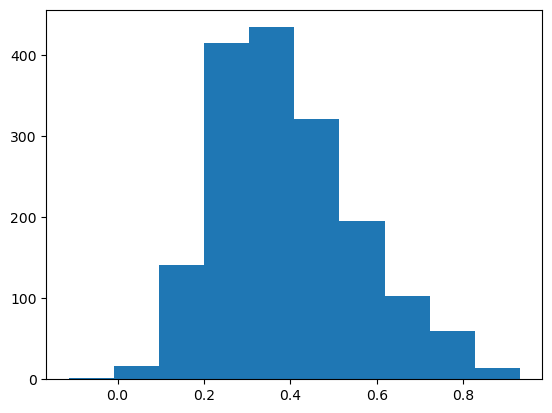

In [118]:
plt.hist(Train_SemEval.df["MiniLM"])

In [119]:
Train_SemEval.df["MiniLM"].to_numpy().min(), Train_SemEval.df["MiniLM"].to_numpy().max()

(-0.11255282163619995, 0.9304733276367188)

In [108]:
from lazypredict.Supervised import LazyClassifier

features = ['Roberta', 'MiniLM', 'Marco', 'distilroberta']

X_train = Train_SemEval.df[features]
y_train = Train_SemEval.df.label

X_val = Val_SemEval.df[features]
y_val = Val_SemEval.df.label

X_test = Test_SemEval.df[features]
y_test = Test_SemEval.df.label

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_val, y_train, y_val)

print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 13.23it/s]

[LightGBM] [Info] Number of positive: 850, number of negative: 850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1700, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NuSVC                              0.55               0.55     0.55      0.54   
LinearSVC                          0.54               0.54     0.54      0.53   
LinearDiscriminantAnalysis         0.54               0.54     0.54      0.53   
RidgeClassifierCV                  0.54               0.54     0.54      0.53   
RidgeClassifier                    0.54               0.54     0.54      0.53   


In [114]:
from sklearn.svm import NuSVC

clf = NuSVC()

clf.fit(X_train, y_train)
preds = clf.predict(X_test)
np.save('TestSecond.npy', preds)